In [139]:
# Uncomment this cell, Run this, comment cell, restart runtime and run everything else
# !pip install --upgrade matplotlib

In [140]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib 
import seaborn as sns
import os
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif, SelectKBest
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
import joblib
import sys
sys.modules['sklearn.externals.joblib'] = joblib
from mlxtend.feature_selection import ExhaustiveFeatureSelector
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn import metrics
from sklearn.metrics import classification_report

In [141]:
from google.colab import drive
drive.mount('/content/gdrive')

os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"
# /content/gdrive/My Drive/Kaggle is the path where kaggle.json is present in the Google Drive

#changing the working directory
%cd /content/gdrive/My Drive/Kaggle
#Check the present working directory using pwd command

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/Kaggle


**Load Data**

In [142]:
# Reading in Financial and Default Data csv files
financial_data = pd.read_csv("/content/gdrive/MyDrive/Default_Classification /1_Financial Data.csv")
default_data = pd.read_csv("/content/gdrive/MyDrive/Default_Classification /2_Default Data.csv")

In [143]:
# Inspection of first 5 rows of Financial Data
financial_data.head()

,LOAN_ID,PD_RISK_RATING,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15
0,ZZZ0001,2,C&I,0.113703,0.795355,1156188.606,0.090963,0.963879,120.606137,0.966454,-6.884990,0.195105,1.093855,0.890361,C,T982,Yes
1,ZZZ0002,4,CRE Permanent,0.622299,0.364232,NaN,0.497840,0.606212,109.621719,0.440733,-10.010214,1.600637,1.146797,0.857632,B,X456,Yes
2,ZZZ0003,2,CRE Construction,0.609275,0.821238,1046682.630,0.487420,0.296746,94.520306,0.007491,10.726384,0.434792,1.050520,0.150828,B,T982,Yes
3,ZZZ0004,1,CRE Construction,0.623379,0.613073,1085325.470,0.498704,0.641079,94.933871,0.910976,0.476127,0.341299,1.011261,0.120293,B,T982,No
4,ZZZ0005,2,CRE Construction,0.860915,0.709228,1051378.694,0.688732,0.339430,106.331848,0.939269,0.251195,0.967834,1.002241,0.329663,B,R567,Yes


In [144]:
# Shape of Financial Data (Number of Rows, Number of Columns)
financial_data.shape

(10000, 17)

In [145]:
# Inspection of first 5 rows of Default Data
default_data.head()

,Unnamed: 0,LOAN_ID
0,1,ZZZ00085
1,2,ZZZ000101
2,3,ZZZ000108
3,4,ZZZ000119
4,5,ZZZ000258


In [146]:
# Shape of Default Data (Number of Rows, Number of Columns)
default_data.shape

(129, 2)

**Join Financial Data and Default Data by LOAN_ID**

In [147]:
# Merging Financial and Default Dataframes by LOAN_ID and by left table financial data
default_financial_data = pd.merge(financial_data, default_data, on='LOAN_ID', how = 'left')

# Inspection of first 100 rows of default_financial_data 
default_financial_data.head()

,LOAN_ID,PD_RISK_RATING,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,Unnamed: 0
0,ZZZ0001,2,C&I,0.113703,0.795355,1156188.606,0.090963,0.963879,120.606137,0.966454,-6.884990,0.195105,1.093855,0.890361,C,T982,Yes,NaN
1,ZZZ0002,4,CRE Permanent,0.622299,0.364232,NaN,0.497840,0.606212,109.621719,0.440733,-10.010214,1.600637,1.146797,0.857632,B,X456,Yes,NaN
2,ZZZ0003,2,CRE Construction,0.609275,0.821238,1046682.630,0.487420,0.296746,94.520306,0.007491,10.726384,0.434792,1.050520,0.150828,B,T982,Yes,NaN
3,ZZZ0004,1,CRE Construction,0.623379,0.613073,1085325.470,0.498704,0.641079,94.933871,0.910976,0.476127,0.341299,1.011261,0.120293,B,T982,No,NaN
4,ZZZ0005,2,CRE Construction,0.860915,0.709228,1051378.694,0.688732,0.339430,106.331848,0.939269,0.251195,0.967834,1.002241,0.329663,B,R567,Yes,NaN


**NOTE: If LOAN_ID is in Default Dataset, then that LOAN_ID is a DEFAULTED OBLIGOR; otherwise, LOAN_ID is NOT defaulted**

**NOTE: Using 'Unnamed: 0' as a reference to check if that LOAN_ID exists in Default Data or not by checking if the value is NULL or not**

In [148]:
default_financial_data['Default_Ind'] = np.where(default_financial_data['Unnamed: 0'].isnull(), '0', '1')

# Drop 'Unnamed: 0' Column since it is not needed anymore 
default_financial_data.drop('Unnamed: 0', axis = 1, inplace = True)

In [149]:
# Inspection of first 5 rows of default_financial_data 
default_financial_data.head()

,LOAN_ID,PD_RISK_RATING,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,Default_Ind
0,ZZZ0001,2,C&I,0.113703,0.795355,1156188.606,0.090963,0.963879,120.606137,0.966454,-6.884990,0.195105,1.093855,0.890361,C,T982,Yes,0
1,ZZZ0002,4,CRE Permanent,0.622299,0.364232,NaN,0.497840,0.606212,109.621719,0.440733,-10.010214,1.600637,1.146797,0.857632,B,X456,Yes,0
2,ZZZ0003,2,CRE Construction,0.609275,0.821238,1046682.630,0.487420,0.296746,94.520306,0.007491,10.726384,0.434792,1.050520,0.150828,B,T982,Yes,0
3,ZZZ0004,1,CRE Construction,0.623379,0.613073,1085325.470,0.498704,0.641079,94.933871,0.910976,0.476127,0.341299,1.011261,0.120293,B,T982,No,0
4,ZZZ0005,2,CRE Construction,0.860915,0.709228,1051378.694,0.688732,0.339430,106.331848,0.939269,0.251195,0.967834,1.002241,0.329663,B,R567,Yes,0


In [150]:
# Column Names for default_financial_data
default_financial_data.columns

Index(['LOAN_ID', 'PD_RISK_RATING', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7',
       'X8', 'X9', 'X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'Default_Ind'],
      dtype='object')

In [151]:
# Checking data types for Each Column in default_financial_data
default_financial_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   LOAN_ID         10000 non-null  object 
 1   PD_RISK_RATING  10000 non-null  int64  
 2   X1              10000 non-null  object 
 3   X2              9000 non-null   float64
 4   X3              10000 non-null  float64
 5   X4              9000 non-null   float64
 6   X5              10000 non-null  float64
 7   X6              10000 non-null  float64
 8   X7              10000 non-null  float64
 9   X8              10000 non-null  float64
 10  X9              10000 non-null  float64
 11  X10             10000 non-null  float64
 12  X11             10000 non-null  float64
 13  X12             10000 non-null  float64
 14  X13             10000 non-null  object 
 15  X14             10000 non-null  object 
 16  X15             10000 non-null  object 
 17  Default_Ind     10000 non-null  

In [152]:
# Shape of default_financial_data (Number of Rows, Number of Columns)
default_financial_data.shape

(10000, 18)

# **Checking and Filling in NULL Values for Columns and for Entire DataFrame**

In [153]:
# Check number of NULL values in entire default_financial_data
default_financial_data.isnull().sum().sum()

2000

In [154]:
# Check number of NULL values for EACH COLUMN in default_financial_data
default_financial_data.isnull().sum()

LOAN_ID              0
PD_RISK_RATING       0
X1                   0
X2                1000
X3                   0
X4                1000
X5                   0
X6                   0
X7                   0
X8                   0
X9                   0
X10                  0
X11                  0
X12                  0
X13                  0
X14                  0
X15                  0
Default_Ind          0
dtype: int64

In [155]:
# Looks like Columns X2 and X4 are the ONLY columns with missing values hence need to fill them in using interpolation 
# based by the combination of PD_RISK_RATING and other CATEGORICAL features X1, X13, X14, X15 and target Default_Ind
default_financial_data['X2'] = default_financial_data.groupby(['PD_RISK_RATING', 'X1', 'X13', 'X14', 'X15', 'Default_Ind'])['X2'].apply(lambda x: 
                                                                                                                         x.interpolate(method = 'linear'))
default_financial_data['X4'] = default_financial_data.groupby(['PD_RISK_RATING', 'X1', 'X13', 'X14', 'X15', 'Default_Ind'])['X4'].apply(lambda x: 
                                                                                                                         x.interpolate(method = 'linear'))

In [156]:
# Check number of NULL values in entire default_financial_data AFTER interpolation to make sure there are NO missing values present
default_financial_data.isnull().sum().sum()

199

In [157]:
# Since there are still some missing values, let's try to fill them in by interpolation 
# based by ONLY on PD_RISK_RATING
default_financial_data['X2'] = default_financial_data.groupby(['PD_RISK_RATING'])['X2'].apply(lambda x: x.interpolate(method = 'linear'))
default_financial_data['X4'] = default_financial_data.groupby(['PD_RISK_RATING'])['X4'].apply(lambda x: x.interpolate(method = 'linear'))

In [158]:
# Let's us again Check number of NULL values in entire default_financial_data AFTER interpolation to make sure there are NO missing values present
default_financial_data.isnull().sum().sum()

6

In [159]:
# Since there are still some missing values, let's fill them up by interpolation REGARDLESS of group(s)
default_financial_data['X2'].interpolate(method = 'linear', inplace = True)
default_financial_data['X4'].interpolate(method = 'linear', inplace = True)

In [160]:
# Last time, Check number of NULL values in entire default_financial_data AFTER interpolation to make sure there are NO missing values present
default_financial_data.isnull().sum().sum()

0

# **Data Analysis and Inference**

In [161]:
# Inspecting first 5 rows of default_financial_data 
default_financial_data.head()

,LOAN_ID,PD_RISK_RATING,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,Default_Ind
0,ZZZ0001,2,C&I,0.113703,0.795355,1156188.606,0.090963,0.963879,120.606137,0.966454,-6.884990,0.195105,1.093855,0.890361,C,T982,Yes,0
1,ZZZ0002,4,CRE Permanent,0.622299,0.364232,1101435.618,0.497840,0.606212,109.621719,0.440733,-10.010214,1.600637,1.146797,0.857632,B,X456,Yes,0
2,ZZZ0003,2,CRE Construction,0.609275,0.821238,1046682.630,0.487420,0.296746,94.520306,0.007491,10.726384,0.434792,1.050520,0.150828,B,T982,Yes,0
3,ZZZ0004,1,CRE Construction,0.623379,0.613073,1085325.470,0.498704,0.641079,94.933871,0.910976,0.476127,0.341299,1.011261,0.120293,B,T982,No,0
4,ZZZ0005,2,CRE Construction,0.860915,0.709228,1051378.694,0.688732,0.339430,106.331848,0.939269,0.251195,0.967834,1.002241,0.329663,B,R567,Yes,0


In [162]:
# Describe the default_financial_data 
default_financial_data.describe()

,PD_RISK_RATING,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12
count,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,2.989500,0.501617,0.500171,9.990328e+05,0.400250,0.495674,100.075516,0.501907,-0.042591,1.631563,1.143796,0.500427
std,1.925035,0.281571,0.334494,9.939076e+04,0.229641,0.290899,10.095165,0.287536,4.994273,2.192588,0.164127,0.291116
min,1.000000,0.000342,0.000148,6.449835e+05,0.000273,0.000065,61.657742,0.000221,-21.008133,0.025342,1.000012,0.000040
25%,1.000000,0.262338,0.250202,9.300804e+05,0.201990,0.242502,93.379452,0.255243,-3.459185,0.506945,1.036493,0.245411
50%,2.000000,0.504040,0.495737,9.996297e+05,0.401013,0.491026,100.141522,0.502186,-0.035816,0.996286,1.091469,0.497968
75%,4.000000,0.739886,0.743321,1.066265e+06,0.597996,0.749245,106.787248,0.753215,3.339370,1.928394,1.191380,0.756650
max,10.000000,0.999594,10.124300,1.372729e+06,0.799675,0.999974,136.910817,0.999973,20.234146,40.065646,2.994919,0.999975


### **Categories for PD_RISK_RATING**

In [163]:
# Number of Observations for each Category in Column X1
pd.DataFrame(default_financial_data.groupby('PD_RISK_RATING')['PD_RISK_RATING'].count())

,PD_RISK_RATING
PD_RISK_RATING,
1,2748
2,2595
3,1069
4,1164
5,1447
6,325
7,332
8,297
9,21


Text(0, 0.5, 'Frequency')

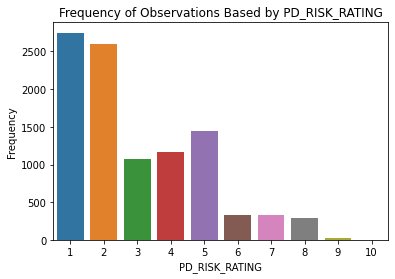

In [164]:
sns.countplot(x='PD_RISK_RATING', data=default_financial_data)
plt.title("Frequency of Observations Based by PD_RISK_RATING")
plt.ylabel("Frequency")

### **List of Categories for Default_Ind Target Variable Column**

### **NOTE: This is an IMBALANCED Binary Classification Dataset**


In [165]:
# Number of Observations for each Category in Column X1
pd.DataFrame(default_financial_data.groupby('Default_Ind')['Default_Ind'].count())

,Default_Ind
Default_Ind,
0,9871
1,129


Text(0, 0.5, 'Frequency')

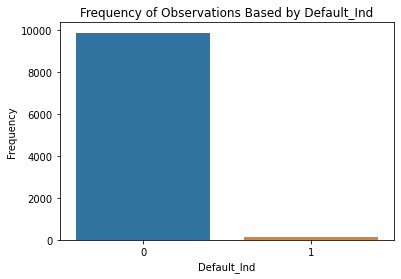

In [166]:
sns.countplot(x='Default_Ind', data=default_financial_data)
plt.title("Frequency of Observations Based by Default_Ind")
plt.ylabel("Frequency")

## **List of Categories for Each of Categorical Feature Variables Columns:**

*   X1
*   X13
*   X14
*   X15

**X1**

In [167]:
# Number of Observations for each Category in Column X1
pd.DataFrame(default_financial_data.groupby('X1')['X1'].count())

,X1
X1,
C&I,3303
CRE Construction,3375
CRE Permanent,3322


Text(0, 0.5, 'Frequency')

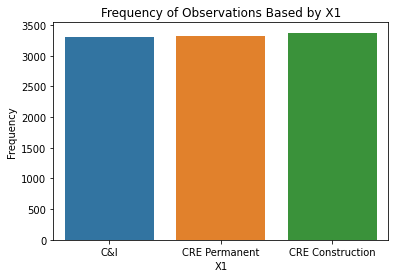

In [168]:
sns.countplot(x='X1', data=default_financial_data)
plt.title("Frequency of Observations Based by X1")
plt.ylabel("Frequency")

**X13**

In [169]:
# Number of Observations for each Category in Column X13
pd.DataFrame(default_financial_data.groupby('X13')['X13'].count())

,X13
X13,
A,3270
B,3346
C,3384


Text(0, 0.5, 'Frequency')

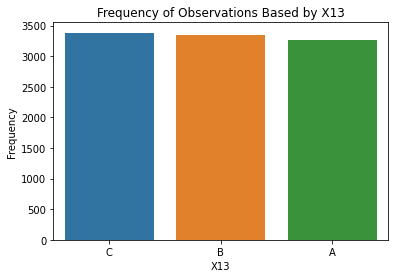

In [170]:
sns.countplot(x='X13', data=default_financial_data)
plt.title("Frequency of Observations Based by X13")
plt.ylabel("Frequency")

**X14**

In [171]:
# Number of Observations for each Category in Column X14
pd.DataFrame(default_financial_data.groupby('X14')['X14'].count())

,X14
X14,
R567,1997
T982,1983
X456,1958
Y237,2035
Z009,2027


Text(0, 0.5, 'Frequency')

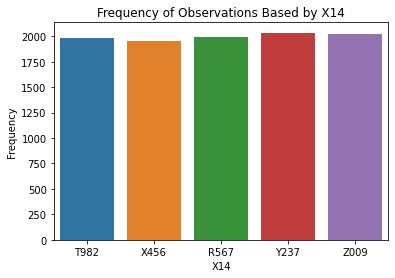

In [172]:
sns.countplot(x='X14', data=default_financial_data)
plt.title("Frequency of Observations Based by X14")
plt.ylabel("Frequency")

**X15**

In [173]:
# Number of Observations for each Category in Column X15
pd.DataFrame(default_financial_data.groupby('X15')['X15'].count())

,X15
X15,
No,5104
Yes,4896


Text(0, 0.5, 'Frequency')

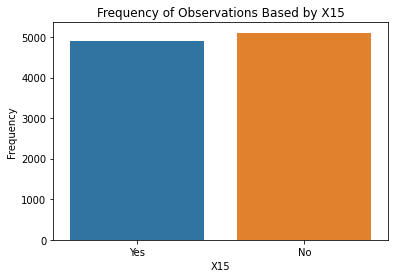

In [174]:
sns.countplot(x='X15', data=default_financial_data)
plt.title("Frequency of Observations Based by X15")
plt.ylabel("Frequency")

**List of Categorical and Continuous Features**

**List of Features and Target**

**Features Dataframe and Target Series**

In [175]:
# Drop columns LOAN_ID and PD_RISK_RATING from default_financial_data since we don't need them anymore in our dataset
default_financial_data.drop(columns=['LOAN_ID', 'PD_RISK_RATING'], inplace=True)

# Inspect first 5 rows of new default_financial_data 
default_financial_data.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,Default_Ind
0,C&I,0.113703,0.795355,1156188.606,0.090963,0.963879,120.606137,0.966454,-6.884990,0.195105,1.093855,0.890361,C,T982,Yes,0
1,CRE Permanent,0.622299,0.364232,1101435.618,0.497840,0.606212,109.621719,0.440733,-10.010214,1.600637,1.146797,0.857632,B,X456,Yes,0
2,CRE Construction,0.609275,0.821238,1046682.630,0.487420,0.296746,94.520306,0.007491,10.726384,0.434792,1.050520,0.150828,B,T982,Yes,0
3,CRE Construction,0.623379,0.613073,1085325.470,0.498704,0.641079,94.933871,0.910976,0.476127,0.341299,1.011261,0.120293,B,T982,No,0
4,CRE Construction,0.860915,0.709228,1051378.694,0.688732,0.339430,106.331848,0.939269,0.251195,0.967834,1.002241,0.329663,B,R567,Yes,0


In [176]:
# Categorical features and Continuous features
categorical_feats = ['X1', 'X13', 'X14', 'X15']
continuous_feats = ['X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11', 'X12']

# Features (X1 to X15) and target variable (Default_Ind)
feats = list(default_financial_data.columns)[0:-1]
target = list(default_financial_data.columns)[-1]

# Features dataframe and target series
X = default_financial_data[feats]
y = default_financial_data[target]

**Proportion of Customers in Each Category for Each Categorical Feature (X1, X13, X14, X15) Based by Default_Ind**

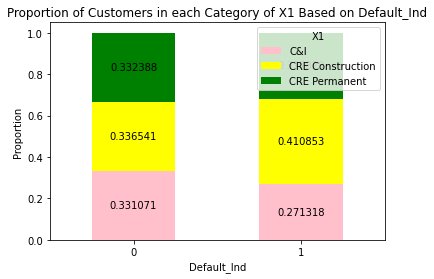

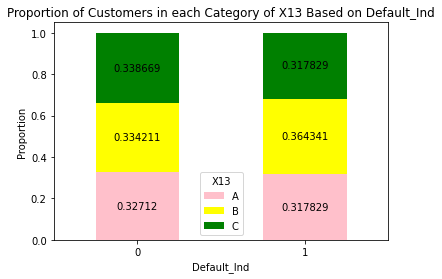

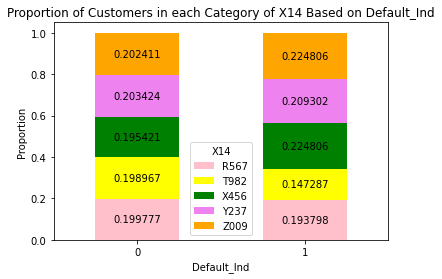

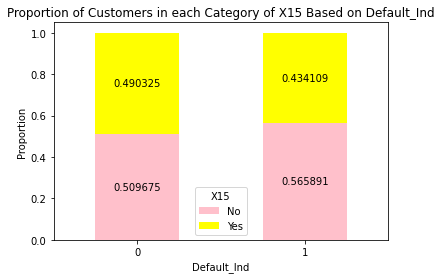

In [177]:
# fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 12))
# plt.subplots_adjust(hspace=0.5)

for categorical_feat in categorical_feats:
# for categorical_feat, axis in zip(categorical_feats, axs.ravel()):
    
  ct = pd.crosstab(default_financial_data[target], default_financial_data[categorical_feat], normalize = 'index')
  
  ax = ct.plot(kind='bar', color=['pink', 'yellow', 'green', 'violet', 'orange'], stacked=True, rot=0)
  title = "Proportion of Customers in each Category of " + categorical_feat + " Based on " + target
  plt.title(title)
  plt.ylabel("Proportion")

  # add annotations if desired
  for c in ax.containers:
    
    # set the bar label
    ax.bar_label(c, label_type='center')
  
  plt.show()

**Averages for Each Continuous Feature (X2 to X12) Based on Default_Ind**

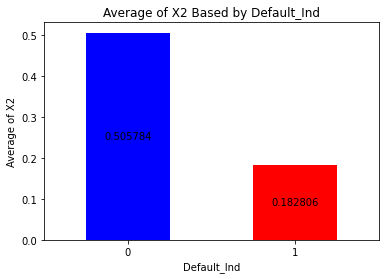

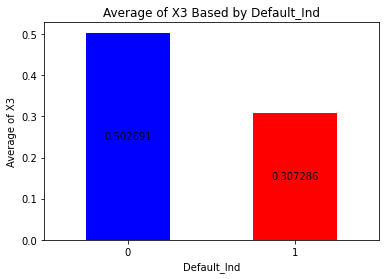

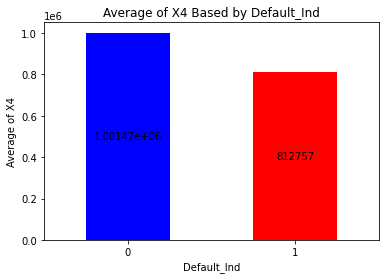

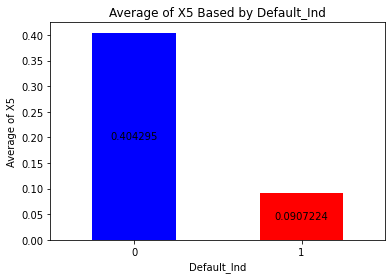

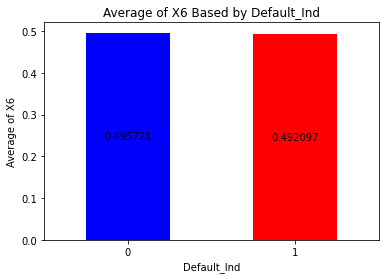

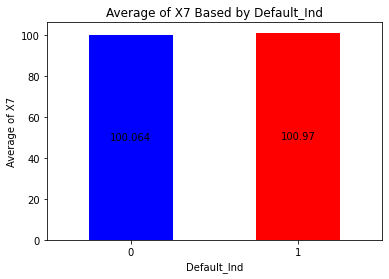

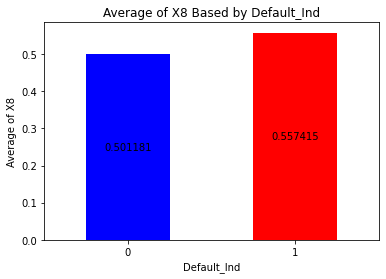

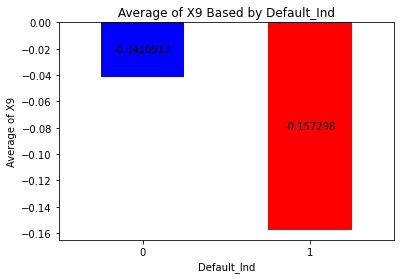

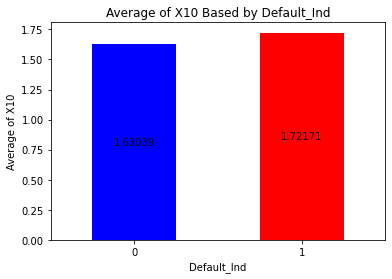

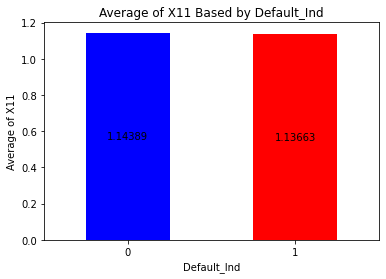

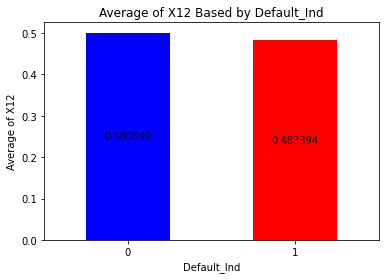

In [178]:
for i, continuous_feat in enumerate(continuous_feats):
  group = default_financial_data.groupby(target)[continuous_feat].mean()
  title = "Average of " + continuous_feat + " Based by " + target
  y_axis_title = "Average of " + continuous_feat
  plt.title(title)
  plt.ylabel(y_axis_title)

  ax = group.plot(kind='bar', color=['blue','red'], stacked=False, rot=0)

  # add annotations if desired
  for c in ax.containers:
        
    # set the bar label
    ax.bar_label(c, label_type='center')
  
  plt.show()

**NOTE: Based on INSTRUCTIONS GIVEN:**

**Treat the first 7,000 observations as your training data and preserve the remaining 3,000 observations for testing model performance.**

**Split Training Set (X_train and y_train) and Testing Set (X_test and y_test)**

In [179]:
# Splitting DataFrame into Training and Testing Sets Based on GIVEN INSTRUCTION
X_train, X_test, y_train, y_test = X.iloc[:7000, ], X.iloc[7000:, ], y.iloc[:7000,], y.iloc[7000:,]

In [180]:
# Checking Number of observations by Default_Ind in y_train
y_train.value_counts()

0    6910
1      90
Name: Default_Ind, dtype: int64

In [181]:
# Checking Number of observations by Default_Ind in y_test
y_test.value_counts()

0    2961
1      39
Name: Default_Ind, dtype: int64

In [182]:
# Inspection of X_train
X_train

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15
0,C&I,0.113703,0.795355,1.156189e+06,0.090963,0.963879,120.606137,0.966454,-6.884990,0.195105,1.093855,0.890361,C,T982,Yes
1,CRE Permanent,0.622299,0.364232,1.101436e+06,0.497840,0.606212,109.621719,0.440733,-10.010214,1.600637,1.146797,0.857632,B,X456,Yes
2,CRE Construction,0.609275,0.821238,1.046683e+06,0.487420,0.296746,94.520306,0.007491,10.726384,0.434792,1.050520,0.150828,B,T982,Yes
3,CRE Construction,0.623379,0.613073,1.085325e+06,0.498704,0.641079,94.933871,0.910976,0.476127,0.341299,1.011261,0.120293,B,T982,No
4,CRE Construction,0.860915,0.709228,1.051379e+06,0.688732,0.339430,106.331848,0.939269,0.251195,0.967834,1.002241,0.329663,B,R567,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6995,CRE Construction,0.783057,0.318378,9.576886e+05,0.298549,0.305136,92.890440,0.371497,-2.059639,0.812265,1.633700,0.160641,B,Y237,Yes
6996,CRE Construction,0.523316,0.429262,1.058638e+06,0.418653,0.084642,88.075916,0.750766,-5.635575,0.416996,1.462425,0.620608,C,R567,Yes
6997,CRE Permanent,0.412300,0.955352,9.692572e+05,0.329840,0.679837,121.769279,0.328850,2.077248,0.198077,1.015395,0.936479,C,Y237,Yes
6998,CRE Permanent,0.214976,0.621003,1.033010e+06,0.171981,0.499849,96.251117,0.561463,1.764575,3.379386,1.159146,0.041222,B,T982,No


In [183]:
# Inspection of X_test
X_test

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15
7000,C&I,0.027298,0.401540,9.300082e+05,0.021838,0.625839,94.380805,0.816985,-7.087859,1.705657,1.152691,0.314339,B,Y237,No
7001,C&I,0.679032,0.848459,9.026285e+05,0.543226,0.689599,101.710382,0.344600,9.508820,0.782513,1.056563,0.979796,A,T982,Yes
7002,CRE Permanent,0.189966,0.633293,9.186776e+05,0.151973,0.648468,94.618248,0.307379,1.989132,0.402333,1.041925,0.452044,B,T982,Yes
7003,C&I,0.919028,0.688461,1.062604e+06,0.735222,0.884885,92.422940,0.160765,-1.401083,1.049699,1.021452,0.744432,A,X456,Yes
7004,CRE Construction,0.523663,0.405373,9.164936e+05,0.418931,0.371590,96.033390,0.053421,4.157838,0.393866,1.005077,0.997030,C,Y237,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,CRE Construction,0.270278,0.008539,8.850822e+05,0.216223,0.182243,93.327910,0.365837,3.216115,0.264882,1.016034,0.939384,C,X456,Yes
9996,CRE Construction,0.475298,0.895215,9.043524e+05,0.380238,0.996613,110.811242,0.402671,5.670780,1.618431,1.008050,0.285680,B,Y237,No
9997,CRE Permanent,0.567873,0.283908,1.148198e+06,0.454298,0.030040,87.192711,0.974729,4.360080,0.270629,1.039594,0.179852,C,Z009,Yes
9998,CRE Permanent,0.386750,0.022000,9.930722e+05,0.309400,0.590155,104.540533,0.957730,-3.032178,0.619714,1.046326,0.729369,A,X456,Yes


In [184]:
# Inspection of y_train
y_train

0       0
1       0
2       0
3       0
4       0
       ..
6995    0
6996    0
6997    0
6998    0
6999    0
Name: Default_Ind, Length: 7000, dtype: object

In [185]:
# Inspection of y_test
y_test

7000    0
7001    0
7002    0
7003    0
7004    0
       ..
9995    0
9996    0
9997    0
9998    0
9999    0
Name: Default_Ind, Length: 3000, dtype: object

# **Univariate Analysis**

In [186]:
# Make a deep copy of features dataframe (X_train) for converting categorical columns to numerical datatype
X_train_copy = X_train.copy()

In [187]:
# Convert each Categorical Feature (X1, X13, X14, X15) into format that can be converted to numerical 
X_train_copy.X1 = X_train_copy.X1.map({'C&I': '0', 'CRE Construction': '1', 'CRE Permanent': '2'})
X_train_copy.X13 = X_train_copy.X13.map({'A': '0', 'B': '1', 'C': '2'})
X_train_copy.X14 = X_train_copy.X14.map({'R567': '0', 'T982': '1', 'X456': '2', 'Y237': '3', 'Z009': '4'})
X_train_copy.X15 = X_train_copy.X15.map({'No': '0', 'Yes': '1'})

# Inspection of first 5 rows of X_train_copy data AFTER converting categorical columns to numerical data type
X_train_copy.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15
0,0,0.113703,0.795355,1156188.606,0.090963,0.963879,120.606137,0.966454,-6.884990,0.195105,1.093855,0.890361,2,1,1
1,2,0.622299,0.364232,1101435.618,0.497840,0.606212,109.621719,0.440733,-10.010214,1.600637,1.146797,0.857632,1,2,1
2,1,0.609275,0.821238,1046682.630,0.487420,0.296746,94.520306,0.007491,10.726384,0.434792,1.050520,0.150828,1,1,1
3,1,0.623379,0.613073,1085325.470,0.498704,0.641079,94.933871,0.910976,0.476127,0.341299,1.011261,0.120293,1,1,0
4,1,0.860915,0.709228,1051378.694,0.688732,0.339430,106.331848,0.939269,0.251195,0.967834,1.002241,0.329663,1,0,1


**Correlation Between Continuous Features**

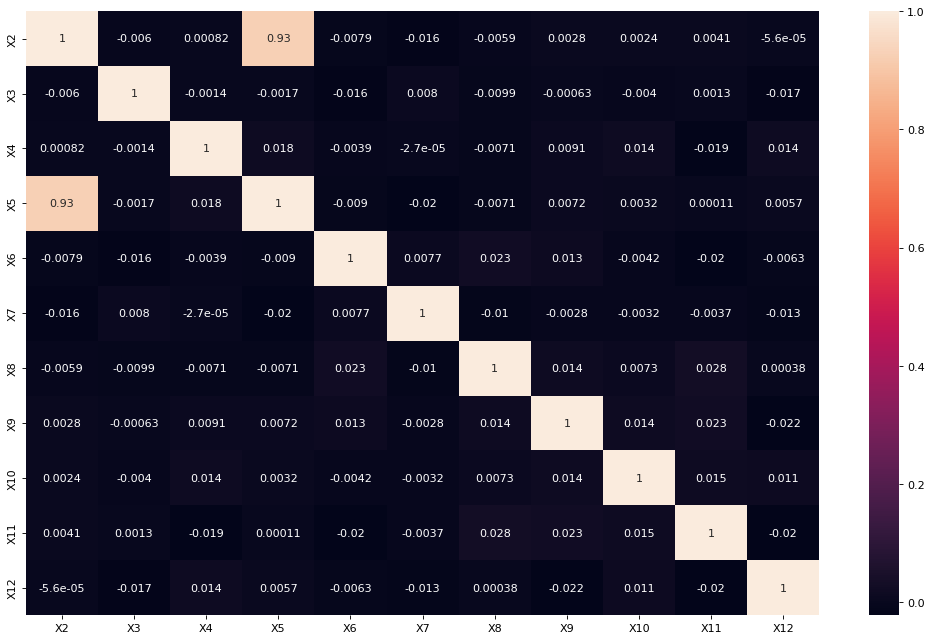

In [188]:
# Correlation Matrix Between Continuous Features (Meaningful Mostly Between Continuous Variables)
from matplotlib.pyplot import figure
figure(figsize = (16, 10), dpi = 80)
corrMatrix = X_train[continuous_feats].corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

**Using Point Biserial Correlation Method to Find the Correlation Between Each Continuous Feature (X2 to X12) and Target Dichotomous Categorical Variable (Default_Ind)**

In [189]:
# Correlation Between Default_Ind and the Continuous Features X2 to X12 (Using Point Biserial Correlation Method)
from scipy import stats

corr_list = []
Y = pd.DataFrame(y_train).astype("int64").squeeze()

for continuous_feat in continuous_feats:
    x = X_train[continuous_feat]
    corr = stats.pointbiserialr(x, Y)
    corr_list.append(corr[0])

df=pd.DataFrame(corr_list, continuous_feats)
df.columns = ['Point Biserial Correlation Coefficient with Default_Ind']
df.sort_values("Point Biserial Correlation Coefficient with Default_Ind")

,Point Biserial Correlation Coefficient with Default_Ind
X4,-0.216395
X5,-0.153333
X2,-0.131106
X3,-0.062800
X11,-0.008640
X10,-0.006302
X12,-0.000015
X9,0.002672
X6,0.009938
X7,0.009991


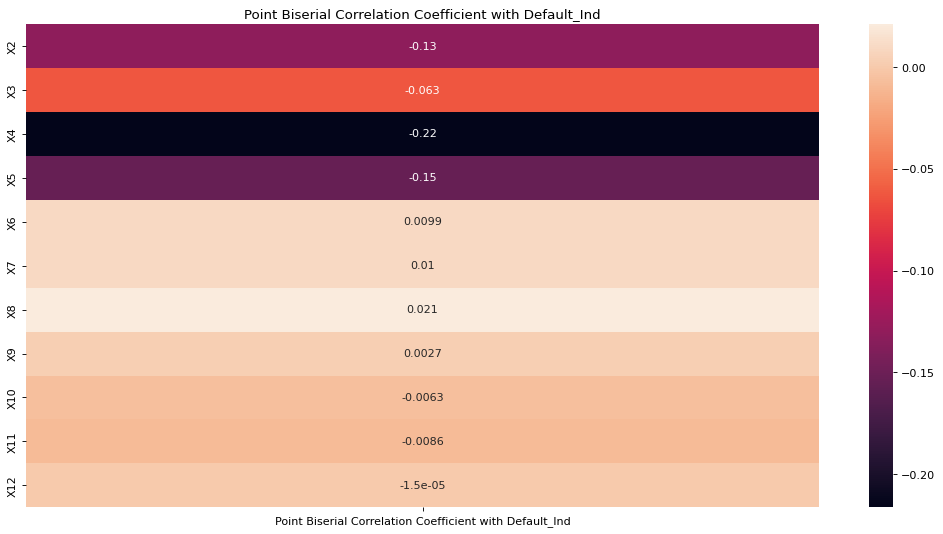

In [190]:
# Correlation Between Default_Ind and the Continuous Features as Heatmap Visualization
figure(figsize = (16, 8), dpi = 80)
sns.heatmap(df, annot=True)
plt.title("Point Biserial Correlation Coefficient with Default_Ind")
plt.show()

**Using Chi-Square Test to Determine whether there is a Correlation Between Each Categorical Feature (X1, X13, X14, X15) and Target Dichotomous Categorical Variable (Default_Ind)**

In [191]:
# Correlation Between Default_Ind and the Categorical Features X1, X13, X14, X15 (Using Chi-Square Test)
from scipy.stats import chi2_contingency 
stat_val_list = []
p_val_list = []
dof_list = []

for categorical_feat in categorical_feats:
  chisqt = pd.crosstab(y_train, X_train[categorical_feat])
  value = np.array([chisqt.iloc[0][0:5].values,
                    chisqt.iloc[1][0:5].values])
  stat_val_list.append(chi2_contingency(value)[0])
  p_val_list.append(chi2_contingency(value)[1])
  dof_list.append(chi2_contingency(value)[2])

df=pd.DataFrame(list(zip(stat_val_list, p_val_list, dof_list)), index = categorical_feats,
             columns = ['Statistical Value with Default_Ind', 'p_Value with Default_Ind','Degrees of Freedom with Default_Ind']) 
df.sort_values("p_Value with Default_Ind")

,Statistical Value with Default_Ind,p_Value with Default_Ind,Degrees of Freedom with Default_Ind
X1,2.257060,0.323508,2
X13,2.068579,0.355479,2
X15,0.429526,0.512222,1
X14,2.310952,0.678776,4


**Information Gain Between Each Feature (X1 to X15) and Target Variable (Default_Ind)**

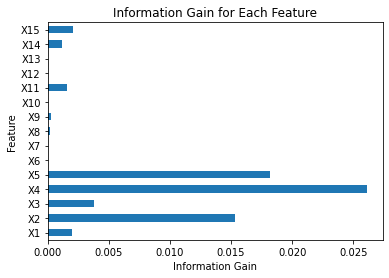

In [192]:
from sklearn.feature_selection import mutual_info_classif
importances = mutual_info_classif(X_train_copy, y_train, discrete_features='auto')
feat_importances = pd.Series(importances, feats)
feat_importances.plot(kind='barh')
plt.title('Information Gain for Each Feature')
plt.ylabel('Feature')
plt.xlabel('Information Gain')
plt.show()

In [193]:
list(pd.Series(importances, feats).sort_values()[-5:].index)

['X15', 'X3', 'X2', 'X5', 'X4']

**Variance Threshold For Each Feature (X1 to X15)**

In [194]:
from sklearn.feature_selection import VarianceThreshold

var_threshold = VarianceThreshold(threshold=0)
var_threshold.fit(X_train_copy)

df=pd.DataFrame(list(var_threshold.get_support()), feats)
df.columns = ['Has Variance Threshold']
df

,Has Variance Threshold
X1,True
X2,True
X3,True
X4,True
X5,True
X6,True
X7,True
X8,True
X9,True
X10,True


**Feature Scores for each Continuous and Categorical Features with Categorical Target (Default_Ind)**

In [195]:
# Select K Best Features Using Univariate Selection (Chi-Squared Test Only For Categorical Features with Categorical Target)
best_features = SelectKBest(score_func = chi2, k = 4)
fit_best_features = best_features.fit(X_train_copy[categorical_feats], y_train) # categorical features only with categorical target

# Get scores for each categorical feature in relation to categorical target (Default_Ind) in one dataframe
scores_df_categorical = pd.DataFrame(fit_best_features.scores_)
features_df_categorical = pd.DataFrame(X_train_copy[categorical_feats].columns)
feature_scores_categorical = pd.concat([features_df_categorical, scores_df_categorical], axis = 1)
feature_scores_categorical.columns = ['Feature', 'Score']
feature_scores_categorical.nlargest(4, 'Score')

,Feature,Score
2,X14,0.500187
3,X15,0.292577
1,X13,0.289865
0,X1,0.010409


In [196]:
# Select K Best Features Using Univariate Selection (ANOVA F-Test Only For Continuous Features with Categorical Target)
best_features = SelectKBest(score_func = f_classif, k = 11)
fit_best_features = best_features.fit(X_train[continuous_feats], y_train) # continuous features only with categorical target 

# Get scores for each continuous feature in relation to categorical target (Default_Ind) in one dataframe
scores_df_regression = pd.DataFrame(fit_best_features.scores_)
features_df_regression = pd.DataFrame(X_train[continuous_feats].columns)
feature_scores_regression = pd.concat([features_df_regression, scores_df_regression], axis = 1)
feature_scores_regression.columns = ['Feature', 'Score']
feature_scores_regression.nlargest(11, 'Score')

,Feature,Score
2,X4,343.791030
3,X5,168.491822
0,X2,122.391666
1,X3,27.708421
6,X8,3.141784
5,X7,0.698572
4,X6,0.691256
9,X11,0.522480
8,X10,0.277978
7,X9,0.049945


In [197]:
# Concat scores for Continuous and Categorical Features Together and Sort them by Score
feature_scores = pd.concat([feature_scores_categorical, feature_scores_regression], axis = 0)
feature_scores.nlargest(15, 'Score')

,Feature,Score
2,X4,343.791030
3,X5,168.491822
0,X2,122.391666
1,X3,27.708421
6,X8,3.141784
5,X7,0.698572
4,X6,0.691256
9,X11,0.522480
2,X14,0.500187
3,X15,0.292577


**Feature Importance Using Extra Trees Decision Classifier**

[0.03035502 0.10671717 0.06884139 0.24624867 0.11787486 0.04530225
 0.05586518 0.04864782 0.04814748 0.04568713 0.04936329 0.04536007
 0.0324987  0.0382786  0.02081238]


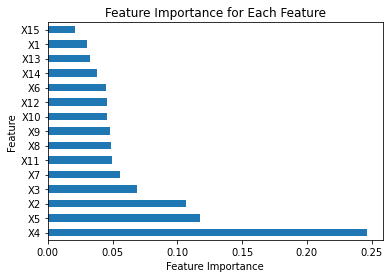

In [198]:
# Feature Importance Using Extra Trees Decision Classifier
from sklearn.ensemble import ExtraTreesClassifier
model = ExtraTreesClassifier()
model.fit(X_train_copy, y_train)
print(model.feature_importances_)

# Plotting graph of feature importance for each feature
feature_importance_dtc = pd.Series(model.feature_importances_, index = X_train_copy.columns)
feature_importance_dtc.nlargest(15).plot(kind = 'barh')
plt.title('Feature Importance for Each Feature')
plt.ylabel('Feature')
plt.xlabel('Feature Importance')
plt.show()

**Feature Importance Using Random Forest Classifier**

[0.00774304 0.11781456 0.06637544 0.35642906 0.15875496 0.03588923
 0.04509117 0.03998095 0.0330771  0.034561   0.04126627 0.0326111
 0.01121266 0.01383499 0.00535848]


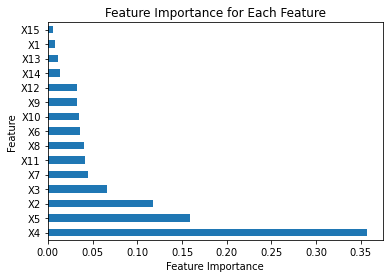

In [199]:
# Feature Importance Using Random Forest Classifier
model = RandomForestClassifier()
model.fit(X_train_copy, y_train)
print(model.feature_importances_)

# Plotting graph of feature importance for each feature
feature_importance_rfc = pd.Series(model.feature_importances_, index = X_train_copy.columns)
feature_importance_rfc.nlargest(15).plot(kind = 'barh')
plt.title('Feature Importance for Each Feature')
plt.ylabel('Feature')
plt.xlabel('Feature Importance')
plt.show()

**Scaling (Standardize/Normalize) Features Function**

In [200]:
# Scaling Training and Testing Dataset to Standardize/Normalize
from sklearn.preprocessing import StandardScaler

def scaling(X_train, X_test):
  scaler = StandardScaler()

  X_train_scale = scaler.fit_transform(X_train)
  X_test_scale = scaler.transform(X_test)

  X_train_scale = pd.DataFrame(X_train_scale, columns = X_train.columns)
  X_test_scale = pd.DataFrame(X_test_scale, columns = X_test.columns)

  return X_train_scale, X_test_scale

**Modelling and Predictions and Model Evaluation Functions**

In [201]:
# Modelling on Revised Training and Testing Dataset 
# Predicting on test set 

def fit_model(model_name, X_train, y_train):
    model = model_name
    model.fit(X_train, y_train)

def train_predict_model(model_name, X_train, X_test, y_train):
    model = model_name
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return y_pred
    
def model_accuracy(model_name, X_train, X_test, y_train, y_test):
    y_pred = train_predict_model(model_name, X_train, X_test, y_train)

    # Use f1-score method to get evaluation of model
    f1_sc = f1_score(y_test, y_pred, labels='binary', pos_label="1")
    return f1_sc

def confusion_matrix(model_name, X_train, X_test, y_train, y_test):
    y_pred = train_predict_model(model_name, X_train, X_test, y_train)
    cm = metrics.confusion_matrix(y_test, y_pred)
    f1_sc = model_accuracy(model_name, X_train, X_test, y_train, y_test)
    plt.figure(figsize=(9,9))
    sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    scores_title = '(F1 Score): {0}'.format(f1_sc)
    plt.title(scores_title, size = 15)

def class_report(model_name, X_train, X_test, y_train, y_test):
  y_pred = train_predict_model(model_name, X_train, X_test, y_train)
  print(classification_report(y_test, y_pred))

**Modify X_train and X_test with Top k Features based on Importance Gain (mutual_info_classif)**

In [202]:
# Modify features dataframe (X) with Top k Features based on Importance Gain (mutual_info_classif)
# Then encode and scale/standardize after Top k features are chosen

def new_train_test_X(k, X_train, X_test, importances=importances):
  top_k_feats = list(pd.Series(importances, feats).sort_values()[-k:].index)

  # Choose k features from dataframe 
  X_train = X_train[top_k_feats]
  X_test = X_test[top_k_feats]

  # One Hot Encoding for categorical features
  X_train_encoded = pd.get_dummies(data = X_train)
  X_test_encoded = pd.get_dummies(data = X_test)

  # Normalization/scaling features 
  X_train_encoded, X_test_encoded = scaling(X_train_encoded, X_test_encoded)

  return X_train_encoded, X_test_encoded

**Logistic Regression search space**

In [203]:
log_model_space = dict()
log_model_space['C'] = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

**Decision Tree Classifier search space**

In [204]:
DTC_model_space = dict()
DTC_model_space['max_depth'] = [1, 10, 25, 50, 75, 100, 1000]

**Support Vector Classifier search space**

In [205]:
SVC_model_space = dict()
SVC_model_space['C'] = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

**KNN Classifier search space**

In [206]:
knn_model_space = dict()
knn_model_space['n_neighbors'] = [1, 5, 10, 25, 50, 75, 100]

**Random Forest Classifier search space**

In [207]:
rfc_model_space = dict()
rfc_model_space['n_estimators'] = [1, 10, 25, 50, 75, 100, 1000]

**XG-Boost Classifier search space**

In [208]:
xgb_model_space = dict()
xgb_model_space['learning_rate'] = [0.01, 0.01, 0.1, 1, 10]
xgb_model_space['n_estimators'] = [1, 10, 25, 50, 75, 100]

**Grid Search CV Function that Selects Hyperparameters based on HIGHEST F1-SCORE**

In [72]:
# from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold

# define evaluation
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

def best_hyperparameters(model_name, space, X_train_encoded):
  model = model_name

  # define search
  search = GridSearchCV(estimator=model, param_grid=space, scoring='f1_macro', n_jobs=-1, cv=10)

  # execute search
  result = search.fit(X_train_encoded, y_train)

  # best parameter(s) that gives HIGHEST f1_macro score
  # print('Best Score: %s' % result.best_score_)
  return result.best_params_

**Using ALL Features OR Using K Selected Features**

In [73]:
# Using ALL Features in the dataframe (is encoded and scaled/normalized in this function)
X_train_encoded_all, X_test_encoded_all = new_train_test_X(15, X_train, X_test)

# Using K Features in the dataframe (is encoded and scaled/normalized in this function)
# Select value for k (number of features wanted in model)
k = 4 
X_train_encoded_k, X_test_encoded_k = new_train_test_X(k, X_train, X_test)

## **Training Classification Models on Training Set and Predicting on Test Set**

# **BASELINE MODEL**: 
**Predicting Whether Customer is in Default Based on ALL FEATURES (X1 TO X15)**

### **Logistic Regression**

**Using ALL FEATURES**

                    
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2961
           1       0.77      0.69      0.73        39

    accuracy                           0.99      3000
   macro avg       0.88      0.84      0.86      3000
weighted avg       0.99      0.99      0.99      3000



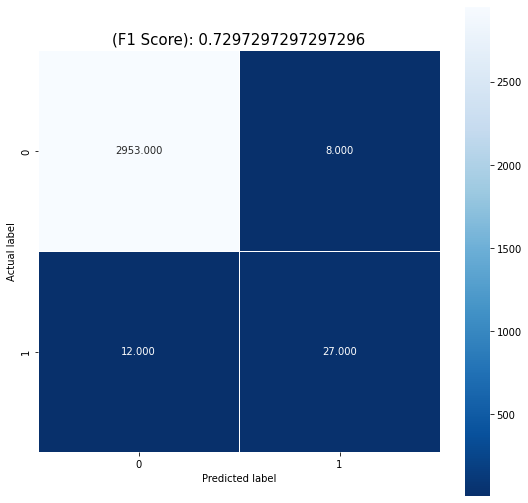

In [74]:
# Optimizing best hyperparameters of Logistic Regression
log_model = LogisticRegression(penalty = 'l1', solver = 'liblinear')
best_params = best_hyperparameters(log_model, log_model_space, X_train_encoded_all)

# Confusion Matrix of Accuracy of Logistic Regression
log_model = LogisticRegression(penalty = 'l1', solver = 'liblinear', C=best_params['C'])
confusion_matrix(log_model, X_train_encoded_all, X_test_encoded_all, y_train, y_test)
print("                    ")

# Classification Report Using Logistic Regression
class_report(log_model, X_train_encoded_all, X_test_encoded_all, y_train, y_test)

**Using TOP K Features based on Information Gain on Target Variable (Default_ind)**

                    
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2961
           1       0.82      0.69      0.75        39

    accuracy                           0.99      3000
   macro avg       0.91      0.85      0.87      3000
weighted avg       0.99      0.99      0.99      3000



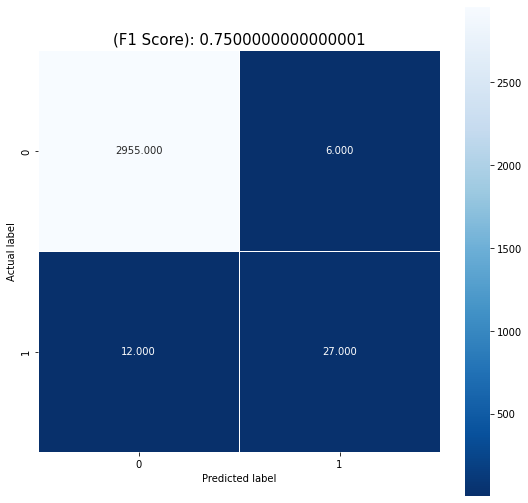

In [75]:
# Optimizing best hyperparameters of Logistic Regression
log_model = LogisticRegression(penalty = 'l1', solver = 'liblinear')
best_params = best_hyperparameters(log_model, log_model_space, X_train_encoded_k)

# Confusion Matrix of Accuracy of Logistic Regression
log_model = LogisticRegression(penalty = 'l1', solver = 'liblinear', C=best_params['C'])
confusion_matrix(log_model, X_train_encoded_k, X_test_encoded_k, y_train, y_test)
print("                    ")

# Classification Report Using Logistic Regression
class_report(log_model, X_train_encoded_k, X_test_encoded_k, y_train, y_test)

### **Decision Tree Classifier**

**Using ALL FEATURES**

                  
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2961
           1       0.66      0.69      0.68        39

    accuracy                           0.99      3000
   macro avg       0.83      0.84      0.84      3000
weighted avg       0.99      0.99      0.99      3000



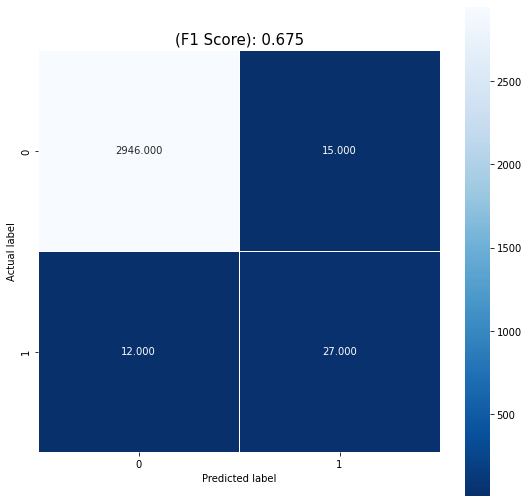

In [76]:
# Optimizing best hyperparameters of Decision Tree Classifier
DTC_model = DecisionTreeClassifier(class_weight='balanced')
best_params = best_hyperparameters(DTC_model, DTC_model_space, X_train_encoded_all)

# Confusion Matrix of Accuracy of Decision Tree Classifier
DTC_model = DecisionTreeClassifier(class_weight='balanced', max_depth=best_params['max_depth'])
confusion_matrix(DTC_model, X_train_encoded_all, X_test_encoded_all, y_train, y_test)
print("                  ")

# Classification Report Using Decision Tree Classifier
class_report(DTC_model, X_train_encoded_all, X_test_encoded_all, y_train, y_test)

**Using TOP K Features based on Information Gain on Target Variable (Default_ind)**

                  
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2961
           1       0.68      0.69      0.68        39

    accuracy                           0.99      3000
   macro avg       0.84      0.84      0.84      3000
weighted avg       0.99      0.99      0.99      3000



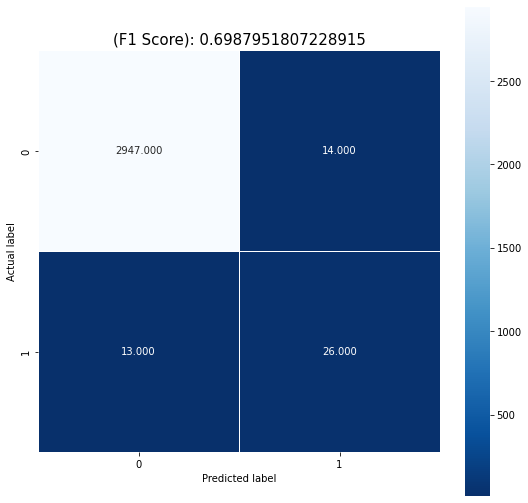

In [77]:
# Optimizing best hyperparameters of Decision Tree Classifier
DTC_model = DecisionTreeClassifier(class_weight='balanced')
best_params = best_hyperparameters(DTC_model, DTC_model_space, X_train_encoded_k)

# Confusion Matrix of Accuracy of Decision Tree Classifier
DTC_model = DecisionTreeClassifier(class_weight='balanced', max_depth=best_params['max_depth'])
confusion_matrix(DTC_model, X_train_encoded_k, X_test_encoded_k, y_train, y_test)
print("                  ")

# Classification Report Using Decision Tree Classifier
class_report(DTC_model, X_train_encoded_k, X_test_encoded_k, y_train, y_test)

### **Support Vector Classifier** 

**Using ALL FEATURES**

         
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      2961
           1       0.56      0.72      0.63        39

    accuracy                           0.99      3000
   macro avg       0.78      0.86      0.81      3000
weighted avg       0.99      0.99      0.99      3000



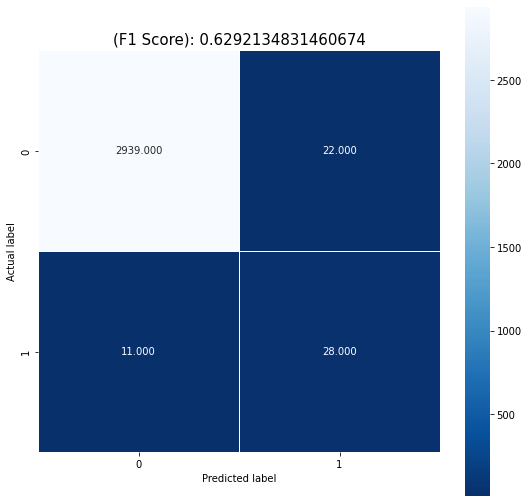

In [78]:
# Optimizing best hyperparameters of Support Vector Classifier
SVC_model = svm.SVC(class_weight='balanced')
best_params = best_hyperparameters(SVC_model, SVC_model_space, X_train_encoded_all)

# Confusion Matrix of Accuracy of Support Vector Classifier
SVC_model = svm.SVC(class_weight='balanced', C=best_params['C'])
confusion_matrix(SVC_model, X_train_encoded_all, X_test_encoded_all, y_train, y_test)
print("         ")

# Classification Report Using Support Vector Classifier
class_report(SVC_model, X_train_encoded_all, X_test_encoded_all, y_train, y_test)

**Using TOP K Features based on Information Gain on Target Variable (Default_ind)**

         
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2961
           1       0.71      0.77      0.74        39

    accuracy                           0.99      3000
   macro avg       0.86      0.88      0.87      3000
weighted avg       0.99      0.99      0.99      3000



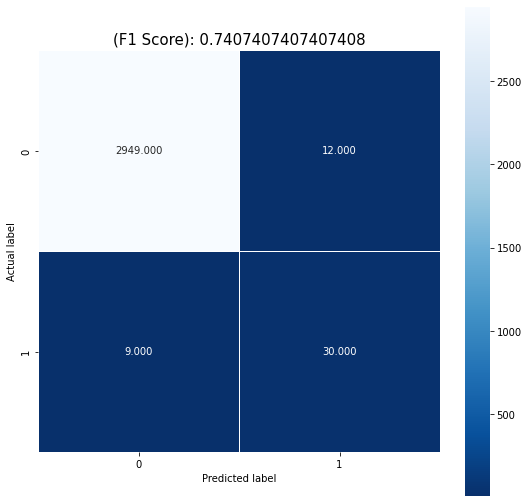

In [79]:
# Optimizing best hyperparameters of Support Vector Classifier
SVC_model = svm.SVC(class_weight='balanced')
best_params = best_hyperparameters(SVC_model, SVC_model_space, X_train_encoded_k)

# Confusion Matrix of Accuracy of Support Vector Classifier
SVC_model = svm.SVC(class_weight='balanced', C=best_params['C'])
confusion_matrix(SVC_model, X_train_encoded_k, X_test_encoded_k, y_train, y_test)
print("         ")

# Classification Report Using Support Vector Classifier
class_report(SVC_model, X_train_encoded_k, X_test_encoded_k, y_train, y_test)

### **K-Nearest_Neighbours Classifier**

**Using ALL FEATURES**

          
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2961
           1       0.31      0.10      0.15        39

    accuracy                           0.99      3000
   macro avg       0.65      0.55      0.57      3000
weighted avg       0.98      0.99      0.98      3000



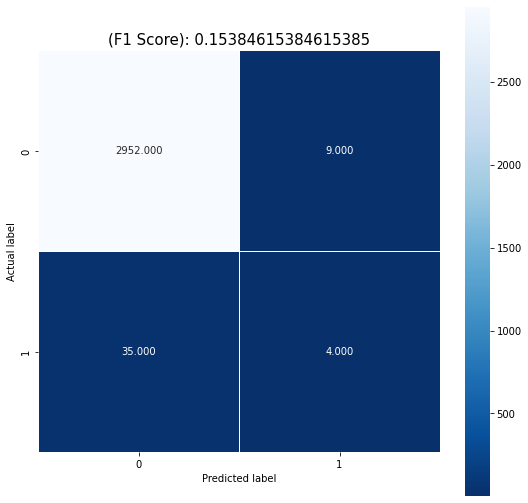

In [80]:
# Optimizing best hyperparameters of K-Nearest Neighbours Classifier
knn_model = KNeighborsClassifier()
best_params = best_hyperparameters(knn_model, knn_model_space, X_train_encoded_all)

# Confusion Matrix of Accuracy of K-Nearest Neighbours Classifier
knn_model = KNeighborsClassifier(n_neighbors=best_params['n_neighbors'])
confusion_matrix(knn_model, X_train_encoded_all, X_test_encoded_all, y_train, y_test)
print("          ")

# Classification Report Using K-Nearest-Neighbours Classifier
class_report(knn_model, X_train_encoded_all, X_test_encoded_all, y_train, y_test)

**Using TOP K Features based on Information Gain on Target Variable (Default_ind)**

          
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2961
           1       0.74      0.67      0.70        39

    accuracy                           0.99      3000
   macro avg       0.87      0.83      0.85      3000
weighted avg       0.99      0.99      0.99      3000



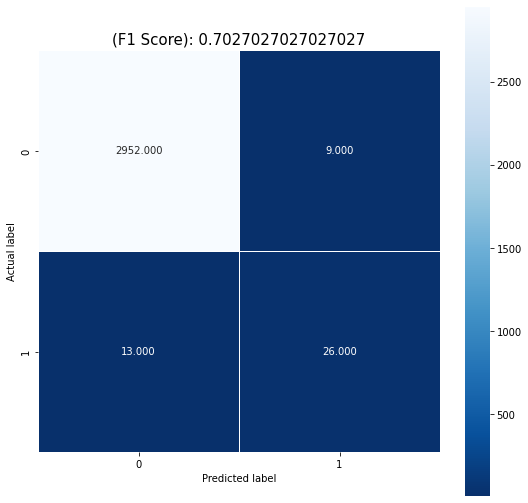

In [81]:
# Optimizing best hyperparameters of K-Nearest Neighbours Classifier
knn_model = KNeighborsClassifier()
best_params = best_hyperparameters(knn_model, knn_model_space, X_train_encoded_k)

# Confusion Matrix of Accuracy of K-Nearest Neighbours Classifier
knn_model = KNeighborsClassifier(n_neighbors=best_params['n_neighbors'])
confusion_matrix(knn_model, X_train_encoded_k, X_test_encoded_k, y_train, y_test)
print("          ")

# Classification Report Using K-Nearest-Neighbours Classifier
class_report(knn_model, X_train_encoded_k, X_test_encoded_k, y_train, y_test)

### **Random Forest Classifier**

**Using ALL FEATURES**

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2961
           1       0.38      0.31      0.34        39

    accuracy                           0.98      3000
   macro avg       0.68      0.65      0.67      3000
weighted avg       0.98      0.98      0.98      3000



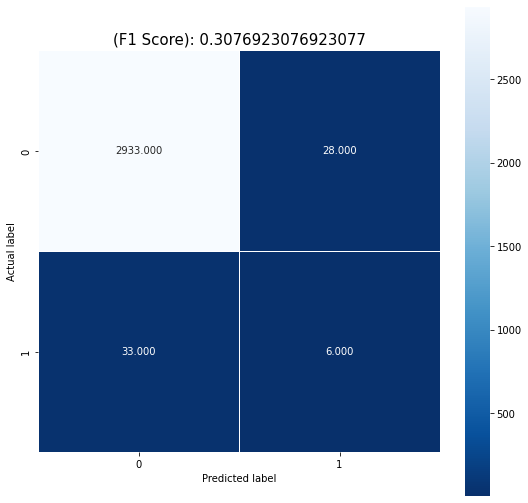

In [82]:
# Optimizing best hyperparameters of Random Forest Classifier 
rfc_model = RandomForestClassifier(class_weight='balanced')
best_params = best_hyperparameters(rfc_model, rfc_model_space, X_train_encoded_all)

# Confusion Matrix of Accuracy of Random Forest Classifier 
rfc_model = RandomForestClassifier(n_estimators=best_params['n_estimators'], class_weight='balanced')
confusion_matrix(rfc_model, X_train_encoded_all, X_test_encoded_all, y_train, y_test)

# Classification Report Using Random Forest Classifier
class_report(rfc_model, X_train_encoded_all, X_test_encoded_all, y_train, y_test)

**Using TOP K Features based on Information Gain on Target Variable (Default_ind)**

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      2961
           1       0.88      0.56      0.69        39

    accuracy                           0.99      3000
   macro avg       0.94      0.78      0.84      3000
weighted avg       0.99      0.99      0.99      3000



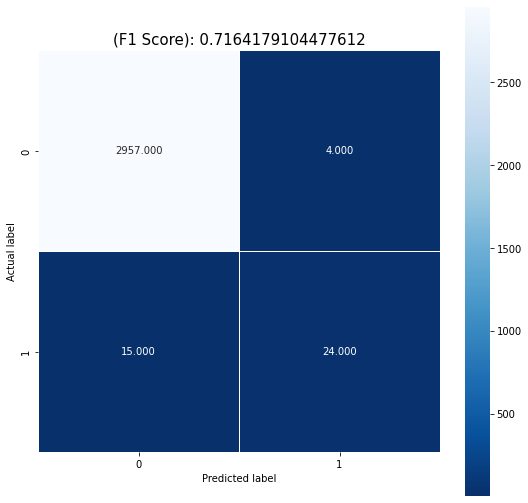

In [83]:
# Optimizing best hyperparameters of Random Forest Classifier 
rfc_model = RandomForestClassifier(class_weight='balanced')
best_params = best_hyperparameters(rfc_model, rfc_model_space,X_train_encoded_k)

# Confusion Matrix of Accuracy of Random Forest Classifier 
rfc_model = RandomForestClassifier(n_estimators=best_params['n_estimators'], class_weight='balanced')
confusion_matrix(rfc_model, X_train_encoded_k, X_test_encoded_k, y_train, y_test)

# Classification Report Using Random Forest Classifier
class_report(rfc_model, X_train_encoded_k, X_test_encoded_k, y_train, y_test)

### **XGBoost Classifier**

**Using ALL FEATURES**

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2961
           1       0.69      0.79      0.74        39

    accuracy                           0.99      3000
   macro avg       0.84      0.90      0.87      3000
weighted avg       0.99      0.99      0.99      3000



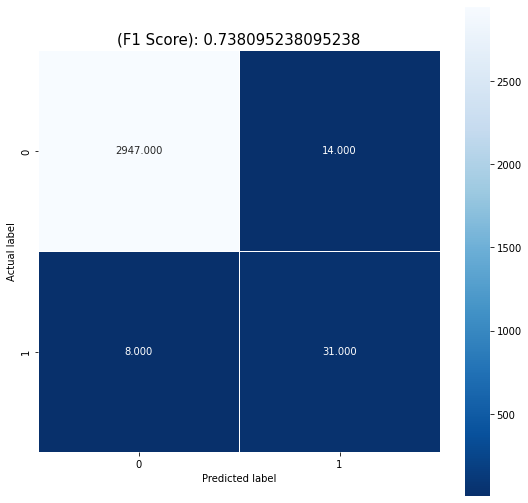

In [84]:
# Optimizing best hyperparameters of xgBoost Classifier
xgb_model = xgb.XGBClassifier(objective='binary:logistic', scale_pos_weight=99)
best_params = best_hyperparameters(xgb_model, xgb_model_space, X_train_encoded_all)

# Confusion Matrix of Accuracy of xgBoost Classifier
xgb_model = xgb.XGBClassifier(objective = 'binary:logistic', scale_pos_weight=99,
                              learning_rate=best_params['learning_rate'], n_estimators=best_params['n_estimators'])
confusion_matrix(xgb_model, X_train_encoded_all, X_test_encoded_all, y_train, y_test)

# Classification Report Using xgBoost Classifier
class_report(xgb_model, X_train_encoded_all, X_test_encoded_all, y_train, y_test)

**Using TOP K Features based on Information Gain on Target Variable (Default_ind)**

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2961
           1       0.76      0.79      0.77        39

    accuracy                           0.99      3000
   macro avg       0.88      0.90      0.89      3000
weighted avg       0.99      0.99      0.99      3000



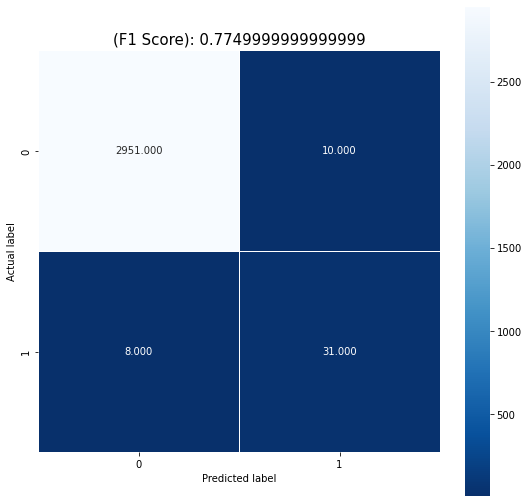

In [85]:
# Optimizing best hyperparameters of xgBoost Classifier
xgb_model = xgb.XGBClassifier(objective='binary:logistic', scale_pos_weight=99)
best_params = best_hyperparameters(xgb_model, xgb_model_space, X_train_encoded_k)

# Confusion Matrix of Accuracy of xgBoost Classifier
xgb_model = xgb.XGBClassifier(objective = 'binary:logistic', scale_pos_weight=99,
                              learning_rate=best_params['learning_rate'], n_estimators=best_params['n_estimators'])
confusion_matrix(xgb_model, X_train_encoded_k, X_test_encoded_k, y_train, y_test)

# Classification Report Using xgBoost Classifier
class_report(xgb_model, X_train_encoded_k, X_test_encoded_k, y_train, y_test)